<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#构建模型的3种方法" data-toc-modified-id="构建模型的3种方法-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>构建模型的3种方法</a></span><ul class="toc-item"><li><span><a href="#使用Sequential按层顺序构建模型" data-toc-modified-id="使用Sequential按层顺序构建模型-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>使用<code>Sequential</code>按层顺序构建模型</a></span></li><li><span><a href="#函数式API创建任意结构模型" data-toc-modified-id="函数式API创建任意结构模型-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>函数式API创建任意结构模型</a></span></li><li><span><a href="#Model子类化创建自定义模型" data-toc-modified-id="Model子类化创建自定义模型-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model子类化创建自定义模型</a></span></li></ul></li><li><span><a href="#训练模型的3种方法" data-toc-modified-id="训练模型的3种方法-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>训练模型的3种方法</a></span><ul class="toc-item"><li><span><a href="#内置fit方法" data-toc-modified-id="内置fit方法-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>内置fit方法</a></span></li><li><span><a href="#内置train_on_batch方法" data-toc-modified-id="内置train_on_batch方法-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>内置train_on_batch方法</a></span></li><li><span><a href="#自定义训练循环" data-toc-modified-id="自定义训练循环-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>自定义训练循环</a></span></li></ul></li></ul></div>

# 构建模型的3种方法

- 使用`Sequential`按层顺序构建模型
- 使用函数式API构建任意结构模型
- 继承`Model`基类构建自定义模型
    - 对于顺序结构的模型，优先使用`Sequential`方法构建。
    - 有多输入或者多输出模型，或者模型需要共享权重，或者模型具有残差连接等非顺序结构，推荐使用函数式API进行创建
    - `Model`子类化的方式，非常灵活，但也有更大的概率出错

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import *

train_token_path = "datasets/imdb/train_token.csv"
test_token_path = "datasets/imdb/test_token.csv"

MAX_WORDS = 10000
MAX_LEN = 200
BATCH_SIZE = 20


# 创建管道
def parse_line(line):
    t = tf.strings.split(line, '\t')
    label = tf.reshape(tf.cast(tf.strings.to_number(t[0]), tf.int32), (-1, ))
    features = tf.cast(tf.strings.to_number(tf.strings.split(t[1], " ")),
                       tf.int32)
    return (features, label)


ds_train = tf.data.TextLineDataset(filenames=[train_token_path]).map(
    parse_line, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(
        buffer_size=1000).batch(BATCH_SIZE).prefetch(
            tf.data.experimental.AUTOTUNE)
ds_test = tf.data.TextLineDataset(filenames=[test_token_path]).map(
    parse_line, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(
        buffer_size=1000).batch(BATCH_SIZE).prefetch(
            tf.data.experimental.AUTOTUNE)

## 使用`Sequential`按层顺序构建模型

In [13]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Embedding(MAX_WORDS, 7, input_length=MAX_LEN))
model.add(layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(layers.MaxPool1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 7)            70000     
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           2304      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [14]:
import datetime
baselogger = callbacks.BaseLogger(stateful_metrics=['AUC'])
logdir = "datasets/keras_model" + datetime.datetime.now().strftime(
    "%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=6,
                    callbacks=[baselogger, tensorboard_callback])

Epoch 1/6
      1/Unknown - 2s 2s/step - loss: 0.6898 - accuracy: 0.7000 - AUC: 0.4702WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.100249). Check your callbacks.
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4997 - accuracy: 0.7149 - AUC: 0.8195 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 2/6
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2723 - accuracy: 0.8946 - AUC: 0.9601 - val_loss: 0.3064 - val_accuracy: 0.8718 - val_AUC: 0.9445
Epoch 3/6
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1814 - accuracy: 0.9349 - AUC: 0.9820 - val_loss: 0.3691 - val_accuracy: 0.8630 - val_AUC: 0.9389
Epoch 4/6
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1177 - accuracy: 0.9609 - AUC: 0.9922 - val_loss: 0.4784 - val_accuracy: 0.8588 - val_AUC: 0.9302
Epoch 5/6
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0673 - accuracy: 

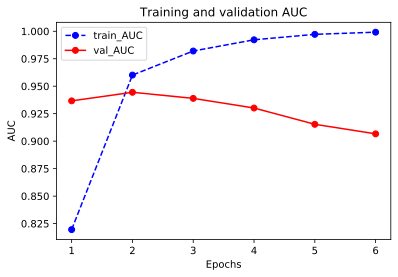

In [16]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

import matplotlib.pyplot as plt


def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title("Training and validation " + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_' + metric, 'val_' + metric])
    plt.show()


plot_metric(history, 'AUC')

## 函数式API创建任意结构模型

In [18]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=[MAX_LEN])
x = layers.Embedding(MAX_WORDS, 7)(inputs)

branch1 = layers.SeparableConv1D(64, 3, activation='relu')(x)
branch1 = layers.MaxPool1D(3)(branch1)
branch1 = layers.SeparableConv1D(32, 3, activation='relu')(branch1)
branch1 = layers.GlobalMaxPool1D()(branch1)

branch2 = layers.SeparableConv1D(64, 5, activation='relu')(x)
branch2 = layers.MaxPool1D(5)(branch2)
branch2 = layers.SeparableConv1D(32, 5, activation='relu')(branch2)
branch2 = layers.GlobalMaxPool1D()(branch2)

branch3 = layers.SeparableConv1D(64, 7, activation='relu')(x)
branch3 = layers.MaxPool1D(7)(branch3)
branch3 = layers.SeparableConv1D(32, 7, activation='relu')(branch3)
branch3 = layers.GlobalMaxPool1D()(branch3)

concat = layers.Concatenate()([branch1, branch2, branch3])
outputs = layers.Dense(1, activation='sigmoid')(concat)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 7)       70000       input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 198, 64)      533         embedding[0][0]                  
__________________________________________________________________________________________________
separable_conv1d_2 (SeparableCo (None, 196, 64)      547         embedding[0][0]                  
______________________________________________________________________________________________

In [20]:
import datetime
logdir = 'datasets/keras_model/' + datetime.datetime.now().strftime(
    '%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=6,
                    callbacks=[tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 12s 12ms/step - loss: 0.5512 - accuracy: 0.6750 - AUC: 0.7698 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 2/6
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3239 - accuracy: 0.8696 - AUC: 0.9421 - val_loss: 0.3347 - val_accuracy: 0.8552 - val_AUC: 0.9329
Epoch 3/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2300 - accuracy: 0.9143 - AUC: 0.9703 - val_loss: 0.3491 - val_accuracy: 0.8536 - val_AUC: 0.9340
Epoch 4/6
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1600 - accuracy: 0.9459 - AUC: 0.9855 - val_loss: 0.4128 - val_accuracy: 0.8538 - val_AUC: 0.9319
Epoch 5/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1059 - accuracy: 0.9678 - AUC: 0.9935 - val_loss: 0.4909 - val_accuracy: 0.8534 - val_AUC: 0.9246
Epoch 6/6
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0591 - accuracy: 0.9850 - 

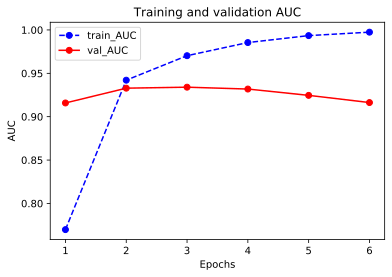

In [21]:
plot_metric(history, "AUC")

## Model子类化创建自定义模型

In [24]:
class ResBlock(layers.Layer):
    def __init__(self, kernel_size, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv1 = layers.Conv1D(filters=64,
                                   kernel_size=self.kernel_size,
                                   activation='relu',
                                   padding='same')
        self.conv2 = layers.Conv1D(filters=32,
                                   kernel_size=self.kernel_size,
                                   activation='relu',
                                   padding='same')
        self.conv3 = layers.Conv1D(filters=input_shape[-1],
                                   kernel_size=self.kernel_size,
                                   activation='relu',
                                   padding='same')
        self.maxpool= layers.MaxPool1D(2)
        super(ResBlock, self).build(input_shape)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = layers.Add()([inputs, x])
        x = self.maxpool(x)
        return x

    # 让自定义的Layer通过函数式API组成模型是可以序列化，需要自定义该方法
    def get_config(self):
        config = super(ResBlock, self).get_config()
        config.update({'kernel_size': self.kernel_size})
        return config

In [25]:
# 测试ResBlock
resblock = ResBlock(kernel_size=3)
resblock.build(input_shape=(None, 200, 7))
resblock.compute_output_shape(input_shape=(None, 200, 7))

TensorShape([None, 100, 7])

In [26]:
class ImdbModel(models.Model):
    def __init__(self):
        super(ImdbModel, self).__init__()

    def build(self, input_shape):
        self.embedding = layers.Embedding(MAX_WORDS, 7)
        self.block1 = ResBlock(7)
        self.block2 = ResBlock(5)
        self.dense = layers.Dense(1, activation='sigmoid')
        super(ImdbModel, self).build(input_shape)

    def call(self, x):
        x = self.embedding(x)
        x = self.block1(x)
        x = self.block2(x)
        x = layers.Flatten()(x)
        x = self.dense(x)
        return x

In [27]:
tf.keras.backend.clear_session()

model = ImdbModel()
model.build(input_shape=(None, 200))
model.summary()

Model: "imdb_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  70000     
_________________________________________________________________
res_block (ResBlock)         multiple                  19143     
_________________________________________________________________
res_block_1 (ResBlock)       multiple                  13703     
_________________________________________________________________
dense (Dense)                multiple                  351       
Total params: 103,197
Trainable params: 103,197
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy', "AUC"])

In [30]:
import datetime

logdir = "datasets/keras_model/" + datetime.datetime.now().strftime(
    "%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=6,
                    callbacks=[tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 10s 10ms/step - loss: 0.5004 - accuracy: 0.7174 - AUC: 0.8197 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 2/6
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2677 - accuracy: 0.8991 - AUC: 0.9617 - val_loss: 0.3105 - val_accuracy: 0.8714 - val_AUC: 0.9458
Epoch 3/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1794 - accuracy: 0.9342 - AUC: 0.9823 - val_loss: 0.3439 - val_accuracy: 0.8640 - val_AUC: 0.9414
Epoch 4/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1166 - accuracy: 0.9584 - AUC: 0.9922 - val_loss: 0.4699 - val_accuracy: 0.8636 - val_AUC: 0.9323
Epoch 5/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0782 - accuracy: 0.9725 - AUC: 0.9962 - val_loss: 0.6080 - val_accuracy: 0.8598 - val_AUC: 0.9221
Epoch 6/6
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0457 - accuracy: 0.9843 - AUC: 0.9

# 训练模型的3种方法
- 内置`fit`方法
- 内置`train_on_batch`方法
- 自定义训练循环

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import *


#打印时间分割线
@tf.function
def printbar():
    ts = tf.timestamp()
    today_ts = ts % (24 * 60 * 60)

    hour = tf.cast(today_ts // 3600 + 8, tf.int32) % tf.constant(24)
    minite = tf.cast((today_ts % 3600) // 60, tf.int32)
    second = tf.cast(tf.floor(today_ts % 60), tf.int32)

    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}", m)) == 1:
            return (tf.strings.format("0{}", m))
        else:
            return (tf.strings.format("{}", m))

    timestring = tf.strings.join(
        [timeformat(hour),
         timeformat(minite),
         timeformat(second)],
        separator=":")
    tf.print("==========" * 8, end="")
    tf.print(timestring)

In [32]:
MAX_LEN = 300
BATCH_SIZE = 32
(x_train, y_train), (x_test, y_test) = datasets.reuters.load_data()
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_LEN)

MAX_WORDS = x_train.max() + 1
CAT_NUM = y_train.max() + 1

ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train)) \
          .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
          .prefetch(tf.data.experimental.AUTOTUNE).cache()

ds_test = tf.data.Dataset.from_tensor_slices((x_test,y_test)) \
          .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
          .prefetch(tf.data.experimental.AUTOTUNE).cache()

PermissionError: [Errno 13] Permission denied: '/home/yangbin7/.keras/datasets/reuters.npz'

## 内置fit方法
通过设置回调函数实现对训练过程的复杂控制逻辑

In [ ]:
tf.keras.backend.clear_session()


def create_model():

    model = models.Sequential()
    model.add(layers.Embedding(MAX_WORDS, 7, input_length=MAX_LEN))
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation="relu"))
    model.add(layers.MaxPool1D(2))
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation="relu"))
    model.add(layers.MaxPool1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(CAT_NUM, activation="softmax"))
    return (model)


def compile_model(model):
    model.compile(optimizer=optimizers.Nadam(),
                  loss=losses.SparseCategoricalCrossentropy(),
                  metrics=[
                      metrics.SparseCategoricalAccuracy(),
                      metrics.SparseTopKCategoricalAccuracy(5)
                  ])
    return (model)


model = create_model()
model.summary()
model = compile_model(model)

In [ ]:
history = model.fit(ds_train, validation_data=ds_test, epochs=10)

## 内置train_on_batch方法
该内置方法相比较fit方法更加灵活，可以不通过回调函数而直接在批次层次上更加精细地控制训练的过程。

In [ ]:
tf.keras.backend.clear_session()


def create_model():
    model = models.Sequential()

    model.add(layers.Embedding(MAX_WORDS, 7, input_length=MAX_LEN))
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation="relu"))
    model.add(layers.MaxPool1D(2))
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation="relu"))
    model.add(layers.MaxPool1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(CAT_NUM, activation="softmax"))
    return (model)


def compile_model(model):
    model.compile(optimizer=optimizers.Nadam(),
                  loss=losses.SparseCategoricalCrossentropy(),
                  metrics=[
                      metrics.SparseCategoricalAccuracy(),
                      metrics.SparseTopKCategoricalAccuracy(5)
                  ])
    return (model)


model = create_model()
model.summary()
model = compile_model(model)

In [ ]:
def train_model(model, ds_train, ds_valid, epoches):

    for epoch in tf.range(1, epoches + 1):
        model.reset_metrics()

        # 在后期降低学习率
        if epoch == 5:
            model.optimizer.lr.assign(model.optimizer.lr / 2.0)
            tf.print("Lowering optimizer Learning Rate...\n\n")

        for x, y in ds_train:
            train_result = model.train_on_batch(x, y)

        for x, y in ds_valid:
            valid_result = model.test_on_batch(x, y, reset_metrics=False)

        if epoch % 1 == 0:
            printbar()
            tf.print("epoch = ", epoch)
            print("train:", dict(zip(model.metrics_names, train_result)))
            print("valid:", dict(zip(model.metrics_names, valid_result)))
            print("")

In [ ]:
train_model(model,ds_train,ds_test,10)

## 自定义训练循环
自定义训练循环无需编译模型，直接利用优化器根据损失函数反向传播迭代参数，拥有最高的灵活性

In [ ]:
tf.keras.backend.clear_session()


def create_model():

    model = models.Sequential()

    model.add(layers.Embedding(MAX_WORDS, 7, input_length=MAX_LEN))
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation="relu"))
    model.add(layers.MaxPool1D(2))
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation="relu"))
    model.add(layers.MaxPool1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(CAT_NUM, activation="softmax"))
    return (model)


model = create_model()
model.summary()

In [ ]:
optimizer = optimizers.Nadam()
loss_func = losses.SparseCategoricalCrossentropy()

train_loss = metrics.Mean(name='train_loss')
train_metric = metrics.SparseCategoricalAccuracy(name='train_accuracy')

valid_loss = metrics.Mean(name='valid_loss')
valid_metric = metrics.SparseCategoricalAccuracy(name='valid_accuracy')


@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features, training=True)
        loss = loss_func(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(loss)
    train_metric.update_state(labels, predictions)


@tf.function
def valid_step(model, features, labels):
    predictions = model(features)
    batch_loss = loss_func(labels, predictions)
    valid_loss.update_state(batch_loss)
    valid_metric.update_state(labels, predictions)


def train_model(model, ds_train, ds_valid, epochs):
    for epoch in tf.range(1, epochs + 1):

        for features, labels in ds_train:
            train_step(model, features, labels)

        for features, labels in ds_valid:
            valid_step(model, features, labels)

        logs = 'Epoch={},Loss:{},Accuracy:{},Valid Loss:{},Valid Accuracy:{}'

        if epoch % 1 == 0:
            printbar()
            tf.print(
                tf.strings.format(
                    logs, (epoch, train_loss.result(), train_metric.result(),
                           valid_loss.result(), valid_metric.result())))
            tf.print("")

        train_loss.reset_states()
        valid_loss.reset_states()
        train_metric.reset_states()
        valid_metric.reset_states()


train_model(model, ds_train, ds_test, 10)